# Попробуем получать от модели pydantic схемы

In [1]:
import os

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(usecwd=True))


BASE_URL = os.getenv("LITELLM_BASE_URL", "http://a6k2.dgx:34000/v1")
API_KEY = os.getenv("OPENAPI_API_KEY", "")
MODEL_NAME = os.getenv("MODEL_NAME", "qwen3-32b")

# Тут интересно было как можно изменять промпт на лету + стримить данные

In [13]:
from langchain_deepseek import ChatDeepSeek
from langchain_core.prompts import ChatPromptTemplate

llm_reasoning = ChatDeepSeek(
    api_base=BASE_URL,
    base_url=BASE_URL,
    api_key=API_KEY,
    model=MODEL_NAME,
    streaming=True
)

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant that speaks {language} and specializes in {domain}."),
    ("human", "Tell me a joke about {topic}. Make it {difficulty} difficulty."),
])

chain = prompt | llm_reasoning

async for chunk in chain.astream({
    "language": "Russian",
    "domain": "programming",
    "topic": "Python developers",
    "difficulty": "hard"
}):
    print(chunk.content, end="", flush=True)



Here's a joke for Python developers that requires some technical knowledge:

**"Why do Python developers always carry a mirror?**  
*Because they want to reflect on the Zen of Python and ensure their code is as beautiful as possible.*"

**Explanation:**  
- **`import this`**: The "Zen of Python" is a collection of 19 aphorisms about programming and design in Python, accessible via `import this`.  
- **Reflection**: In Python, the `__dict__` or `dir()` functions allow introspection (reflecting on an object's structure), but the joke uses the wordplay of "reflect" as in *contemplate*.  
- **Readability counts**: One of the Zen's key principles is "Readability counts," implying developers aim for clean, elegant code.  

The humor lies in the double meaning of "reflect" and the nod to Python's philosophical underpinnings. 😄

# Учусь в structured output

In [15]:
from textwrap import dedent
from langchain_core.output_parsers import StrOutputParser

prompt = ChatPromptTemplate.from_messages([
    (
        "system", 
        dedent(
            """
            You are a helpful assistant. 
            Your goal is to extract user (is it employee) related information from the text provided by the user.
            Return the information in the following JSON-format.
            ```json
            {{
                "users": [
                    {{
                        "name": "user name",
                        "surname": "user surname",
                        "position": "the position where the person works"
                    }}
                ]
            }}
            ```
            if there is no users (employees), return an empty list.
            /no_think
            """
        )
    ),
    (
        "human", 
        dedent(
            """
            Text: {text}"
            """
        )
    ),
])

chain = (
    prompt 
    | llm_reasoning 
    | StrOutputParser()
)


text = """
    Наш бекенд разработчик Семён Владороев полный кретин
"""
response = await chain.ainvoke({"text": text})
print(response)



```json
{
    "users": [
        {
            "name": "Семён",
            "surname": "Владороев",
            "position": "бекенд разработчик"
        }
    ]
}
```


In [19]:
from re import A
from pydantic import BaseModel
from langchain_core.output_parsers import PydanticOutputParser



prompt = ChatPromptTemplate.from_messages([
    (
        "system", 
        dedent(
            """
            You are a helpful assistant. 
            Your goal is to extract user (is it employee) related information from the text provided by the user.
            Return the information in the following JSON-format.
            {fmt}
            """
        )
    ),
    (
        "human", 
        dedent(
            """
            Text: {text}"
            """
        )
    ),
])

class User(BaseModel):
    name: str
    surname: str
    position: str

class Users(BaseModel):
    users: list[User]

parser = PydanticOutputParser(pydantic_object=Users)
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"$defs": {"User": {"properties": {"name": {"title": "Name", "type": "string"}, "surname": {"title": "Surname", "type": "string"}, "position": {"title": "Position", "type": "string"}}, "required": ["name", "surname", "position"], "title": "User", "type": "object"}}, "properties": {"users": {"items": {"$ref": "#/$defs/User"}, "title": "Users", "type": "array"}}, "required": ["users"]}
```


In [20]:
chain = (
    prompt 
    | llm_reasoning 
    | parser
)

response = await chain.ainvoke({"text": text, "fmt": parser.get_format_instructions()})
print(response)

users=[User(name='Семён', surname='Владороев', position='бекенд разработчик')]


# Попробуем вызвать простенький tool

In [35]:
def multiply(a: int, b: int) -> int:
    """Multiply a on b"""
    return a * b

def divide(a: int, b: int) -> float:
    """Divide a on b"""
    if b == 0:
        return ValueError("B should be not equals to 0")
    return a / b

In [36]:
tools = [multiply, divide]

llm_with_tools = llm_reasoning.bind_tools(tools)

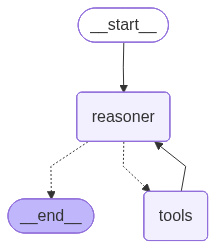

In [37]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")

def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")
builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [48]:
messages = [HumanMessage(content="Calculate: 5x8")]
messages = await react_graph.ainvoke({"messages": messages})

/var/folders/lf/_q0_hq0s659c3bplsjhpdskr0000gn/T/ipykernel_90318/3959093400.py:1: RuntimeWarning: coroutine 'Pregel.ainvoke' was never awaited
  messages = [HumanMessage(content="Calculate: 5x8")]


In [49]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Calculate: 5x8
================================== Ai Message ==================================
Tool Calls:
  multiply (chatcmpl-tool-dad4621e692e447fb75b5200a91c1122)
 Call ID: chatcmpl-tool-dad4621e692e447fb75b5200a91c1122
  Args:
    a: 8
================================= Tool Message =================================
Name: multiply

Error invoking tool 'multiply' with kwargs {'a': 8} with error:
 b: Field required
 Please fix the error and try again.
================================== Ai Message ==================================
Tool Calls:
  multiply (chatcmpl-tool-b18c2b26bcdb4cd08bfa7858ae972cc1)
 Call ID: chatcmpl-tool-b18c2b26bcdb4cd08bfa7858ae972cc1
  Args:
    a: 8
================================= Tool Message =================================
Name: multiply

Error invoking tool 'multiply' with kwargs {'a': 8} with error:
 b: Field required
 Please fix the error and try again.
===============